In [53]:
import pandas as pd
import os
import torch
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import glob
import re
import xml.etree.ElementTree as ET
import sys
import numpy as np
np.random.seed(42)

In [54]:
# Suppress log messages
import logging, sys
logging.disable(sys.maxsize)

In [55]:
#Function for parsing the files from the dataset to a pandas dataframe
def create_df(files):
    data = {'keywords':[], 'sentence':[], 'category':[]}
    for file in tqdm(files):
        tree = ET.parse(file)
        root = tree.getroot()
        for entry in root[0]:
            keywords = []
            sentences = []
            category = entry.attrib['category']
            for elem in entry.findall('./modifiedtripleset/mtriple'):
                keywords.append(elem.text)
            for elem in entry.findall('./lex'):
                sentences.append(elem.text)
            for words in keywords:
                tmp_list = []
                for text in sentences:
                    data['keywords'].append(re.sub('"', '', words))
                    data['sentence'].append(text)
                    data['category'].append(category)

        df = pd.DataFrame(data)
    return df

In [56]:
files = glob.glob("dataset\\train\\**\\*.xml", recursive=True)
print(files[:5])

['dataset\\train\\1triples\\Airport_allSolutions.xml', 'dataset\\train\\1triples\\Artist_allSolutions.xml', 'dataset\\train\\1triples\\Astronaut_allSolutions.xml', 'dataset\\train\\1triples\\Athlete_allSolutions.xml', 'dataset\\train\\1triples\\Building_allSolutions.xml']


In [57]:
df = create_df(files)

  0%|          | 0/88 [00:00<?, ?it/s]

In [58]:
df = df[df['sentence'].apply(lambda x: len(x) < 110)]
df = df.sample(frac=1).reset_index(drop=True)

df

,keywords,sentence,category
0,"Jones_County,_Texas | country | United_States","Jones County, Texas is within the United States.",City
1,Alan_Shepard | occupation | Test_pilot,"Alan Shepard, who served as a Test pilot, was ...",Astronaut
2,108_St_Georges_Terrace | location | Perth,The 108 St. Georges Terrace is located in Pert...,Building
3,Baked_Alaska | country | France,Baked Alaska is founded in Manuel Valls led Fr...,Food
4,300_North_LaSalle | location | Illinois,"300 North LaSalle, Illinois, with 60 floors, w...",Building
...,...,...,...
33310,Ab_Klink | birthPlace | Stellendam,"Ab Klink, born in Stellendam, attended Leiden ...",Politician
33311,Argentina | language | Spanish_language,The language of Argentina is Spanish.,Politician
33312,320_South_Boston_Building | floorCount | 22,"Completed in 1929, 320 South Boston Building h...",Building
33313,Ahmet_Ertegun | genre | Rock_and_roll,Ahmet Ertegun performs rock and roll music.,Artist


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33315 entries, 0 to 33314
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keywords  33315 non-null  object
 1   sentence  33315 non-null  object
 2   category  33315 non-null  object
dtypes: object(3)
memory usage: 780.9+ KB


In [60]:
#Function for plotting bar chart based on dataframe column
import seaborn as sns

def plot_data(df, column):
    column_plot = df[column].value_counts()
    print(column_plot)
    sns.set(font_scale=0.8)
    plt.figure(figsize = (13,13))
    sns.countplot(x=df[column]);

In [61]:
#Shows the 5 most common keywords in the datset
df['keywords'].value_counts()[:5]

United_States | capital | Washington,_D.C.                             133
United_States | ethnicGroup | African_Americans                        112
United_States | ethnicGroup | Asian_Americans                           99
United_States | ethnicGroup | Native_Americans_in_the_United_States     93
Ajoblanco | country | Spain                                             79
Name: keywords, dtype: int64

Food                    4036
Artist                  3889
City                    3053
MeanOfTransportation    2801
Politician              2626
Building                2574
Athlete                 2509
Airport                 2092
WrittenWork             2077
SportsTeam              1981
Astronaut               1284
Company                 1265
CelestialBody           1264
ComicsCharacter         1074
University               484
Monument                 306
Name: category, dtype: int64


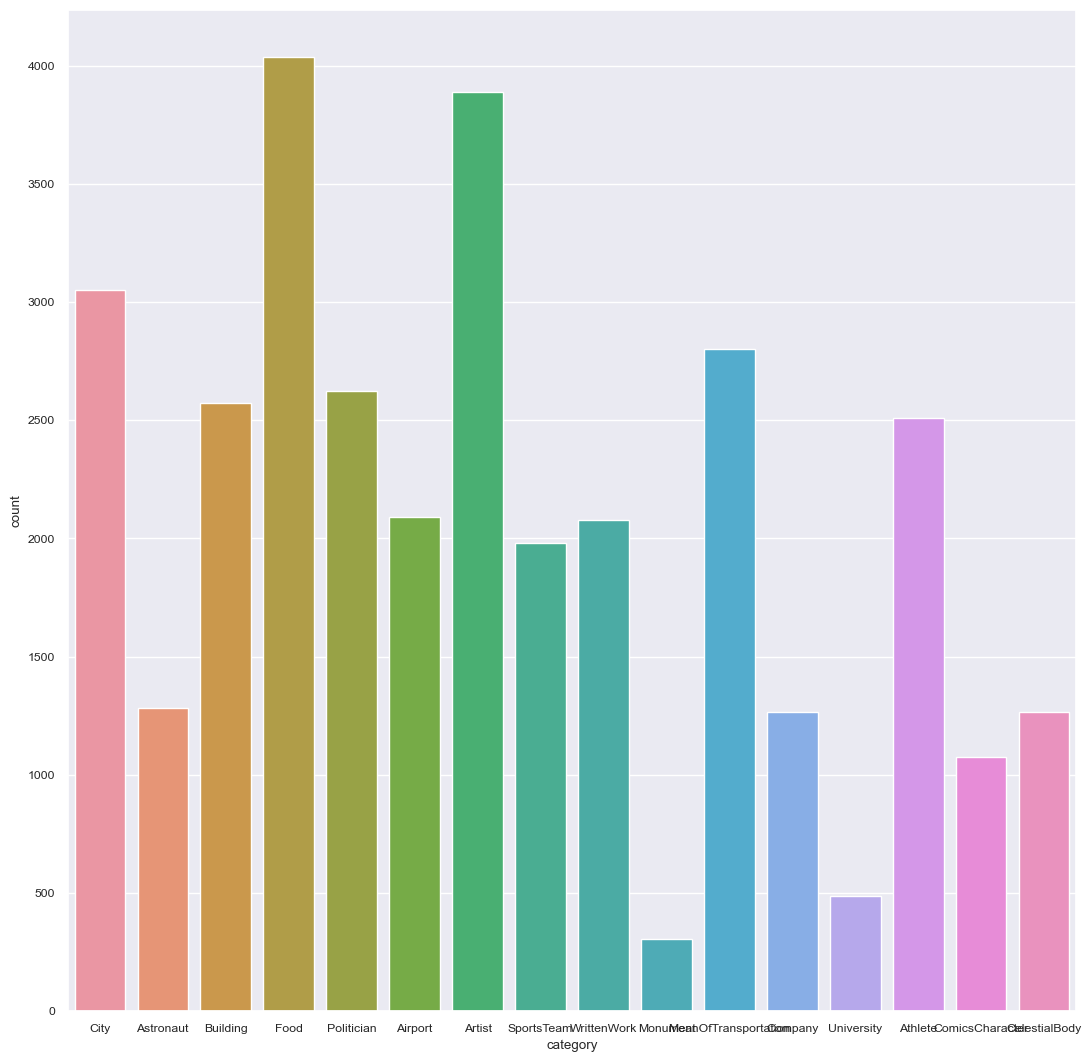

In [62]:
plot_data(df, 'category')

In [63]:
#Removing University and Monument category because of too low amount of training data
df = df[(df['category'] != "Monument") & (df['category'] != "University")]

In [64]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2)

Food                    3237
Artist                  3096
City                    2424
MeanOfTransportation    2228
Politician              2129
Building                2044
Athlete                 2022
WrittenWork             1658
Airport                 1648
SportsTeam              1590
Astronaut               1023
CelestialBody           1015
Company                 1015
ComicsCharacter          891
Name: category, dtype: int64


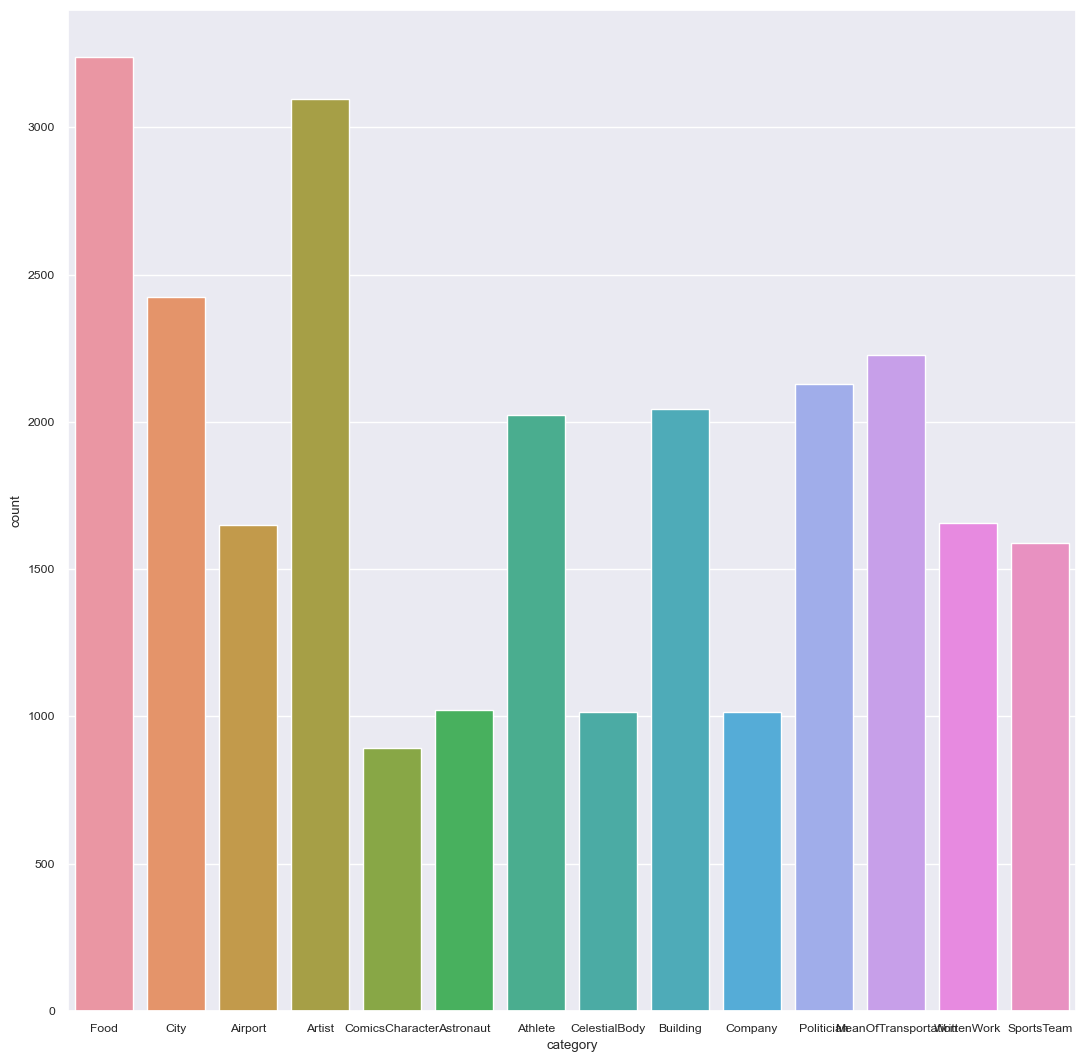

In [65]:
#Plot training data
plot_data(train_df, 'category')

Food                    799
Artist                  793
City                    629
MeanOfTransportation    573
Building                530
Politician              497
Athlete                 487
Airport                 444
WrittenWork             419
SportsTeam              391
Astronaut               261
Company                 250
CelestialBody           249
ComicsCharacter         183
Name: category, dtype: int64


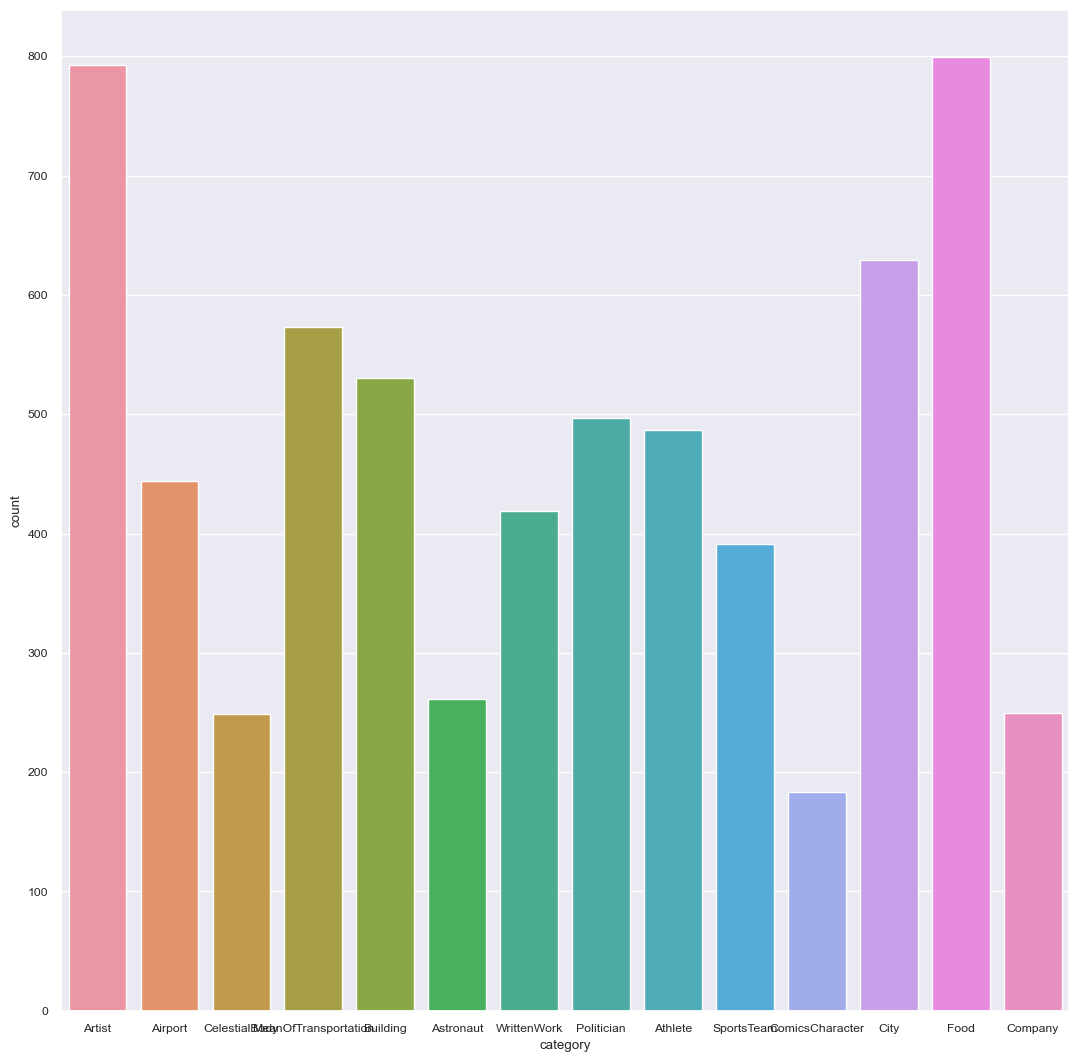

In [66]:
#Plot test data
plot_data(test_df, 'category')

In [67]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

train_df

,keywords,sentence,category
0,Arem-arem | ingredient | Banana_leaf,The Javanese cuisine dish of arem-arem has ban...,Food
1,"Fountain_County,_Indiana | country | United_St...","Attica, Fountain County, Indiana, is found in ...",City
2,Appleton_International_Airport | elevationAbov...,Appleton International Airport elevation above...,Airport
3,Indonesia | language | Indonesian_language,Indonesian is the language of Indonesia where ...,Food
4,Hip_hop_music | derivative | Drum_and_bass,The musical genre of Ace Wilder is hip hop mus...,Artist
...,...,...,...
26015,Alfredo_Zitarrosa | recordLabel | Odeon_Records,Montevidean Milonga singer Alfredo Zitarrosa w...,Artist
26016,Neptun_Werft | city | Rostock,The A Rosa Luna is powered by a MTU Friedrichs...,MeanOfTransportation
26017,"James_Craig_Watson | deathPlace | Madison,_Wis...",101 Helena was discovered by James Craig Watso...,CelestialBody
26018,GMA_New_Media | keyPerson | Felipe_Gozon,"GMA New Media, Inc. is a media company where F...",Company


In [68]:
test_df

,keywords,sentence,category
0,"Alan_Frew | origin | Newmarket,_Ontario","With a background as a solo singer, Alan Frew,...",Artist
1,Tirstrup | isPartOf | Denmark,"Aarhus Airport is in Tirstrup, Denmark which i...",Airport
2,Andrews_County_Airport | 4thRunwayLengthFeet | 25,Andrews County Airport is 973.0 above sea leve...,Airport
3,(66391)_1999_KW4 | escapeVelocity | 0,(66391) 1999 KW4 has an apoapsis of 162164091....,CelestialBody
4,Alfa_Romeo_164 | alternativeName | Alfa Romeo 168,"The Alfa Romeo 164 is also known as the ""Alfa ...",MeanOfTransportation
...,...,...,...
6500,Spain | language | Spanish_language,The Spanish language is spoken in Spain where ...,Politician
6501,Akeem_Ayers | formerTeam | St._Louis_Rams,Akeem Ayers was born on 10th July 1989 and his...,Athlete
6502,(66063)_1998_RO1 | apoapsis | 254989570.60815 ...,(66063) 1998 RO1 has a minimum temperature of ...,CelestialBody
6503,BLT | dishVariation | Club_sandwich,The BLT is a variation of both the club sandwi...,Food


In [69]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("t5-base", model_max_length=512)
model = AutoModelForSeq2SeqLM.from_pretrained("t5-base")

tokenizer(str(train_df[:1]['keywords']))

{'input_ids': [3, 632, 1521, 51, 18, 355, 51, 1820, 11322, 1820, 5185, 152, 9, 834, 109, 9, 89, 5570, 10, 12545, 6, 3, 26, 6137, 10, 3735, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [70]:
import evaluate

bleu = evaluate.load("bleu")

bleu

EvaluationModule(name: "bleu", module_type: "metric", features: [{'predictions': Value(dtype='string', id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='sequence'), length=-1, id='references')}, {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')}], usage: """
Computes BLEU score of translated segments against one or more references.
Args:
    predictions: list of translations to score.
    references: list of lists of or just a list of references for each translation.
    tokenizer : approach used for tokenizing `predictions` and `references`.
        The default tokenizer is `tokenizer_13a`, a minimal tokenization approach that is equivalent to `mteval-v13a`, used by WMT.
        This can be replaced by any function that takes a string as input and returns a list of tokens as output.
    max_order: Maximum n-gram order to use when computing BLEU score.
    smooth: Whether or not to apply Lin et al. 2004 smoot

In [71]:
if not os.path.exists('./new_dataset/'):
    os.mkdir('./new_dataset/')

train_df.to_csv('./new_dataset/train.csv')
test_df.to_csv('./new_dataset/test.csv')

In [72]:
from datasets import load_dataset

data_files = {"train": "train.csv", "test": "test.csv"}
dataset = load_dataset("./new_dataset/", data_files=data_files)

dataset

Generating train split: 0 examples [00:00, ? examples/s]

C:\Users\hakon\anaconda3\envs\tdt13\lib\site-packages\datasets\download\streaming_download_manager.py:714: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to C:/Users/hakon/.cache/huggingface/datasets/csv/new_dataset-ad71db99eec08cf5/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


C:\Users\hakon\anaconda3\envs\tdt13\lib\site-packages\datasets\download\streaming_download_manager.py:714: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'keywords', 'sentence', 'category'],
        num_rows: 26020
    })
    test: Dataset({
        features: ['Unnamed: 0', 'keywords', 'sentence', 'category'],
        num_rows: 6505
    })
})

In [73]:
def preprocess_data(examples):
    inputs = tokenizer(examples["keywords"], max_length=512, padding=True)
    labels = tokenizer(examples["sentence"], max_length=512, padding=True)
    inputs["labels"] = labels["input_ids"]
    return inputs

In [74]:
tokenized_dataset = dataset.map(preprocess_data, batched=True)

tokenized_dataset

  0%|          | 0/27 [00:00<?, ?ba/s]

C:\Users\hakon\anaconda3\envs\tdt13\lib\site-packages\transformers\tokenization_utils_base.py:2322: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'keywords', 'sentence', 'category', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 26020
    })
    test: Dataset({
        features: ['Unnamed: 0', 'keywords', 'sentence', 'category', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 6505
    })
})

In [75]:
import nltk

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    decoded_preds = [''.join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = [nltk.sent_tokenize(label.strip()) for label in decoded_labels]
    
    # Compute BLEU scores
    result = bleu.compute(predictions=decoded_preds, references=decoded_labels)
    
    return result

In [76]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
import wandb

data_collator = DataCollatorForSeq2Seq(tokenizer)

batch_size = 32

args = Seq2SeqTrainingArguments(
    optim='adafactor',
    output_dir='./my_model',
    evaluation_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=100,
    learning_rate=1e-3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    predict_with_generate=True,
    metric_for_best_model="bleu",
    report_to="wandb"
)

In [77]:
model_checkpoint = "t5-base"

def model_init():
    return AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

trainer = Seq2SeqTrainer(
    model_init=model_init,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [78]:
trainer.train()

Step,Training Loss,Validation Loss,Bleu,Precisions,Brevity Penalty,Length Ratio,Translation Length,Reference Length
100,1.112200,0.805303,0.222163,"[0.6619235763821734, 0.3748880557368589, 0.23512867151711128, 0.15116037147018213]",0.724951,0.756630,72386,95669
200,0.752900,0.693117,0.232309,"[0.6848632756750586, 0.40438619951858784, 0.2609099512776473, 0.1738175775918343]",0.693937,0.732400,70068,95669
300,0.673200,0.623603,0.244788,"[0.678253906897123, 0.40451380989215996, 0.2642277790865951, 0.1786625347215661]",0.725613,0.757152,72436,95669
400,0.618000,0.574178,0.252083,"[0.6989919468378668, 0.4254606884366815, 0.28177462166913714, 0.1930192378622872]",0.706862,0.742435,71028,95669
500,0.563700,0.542362,0.257882,"[0.6874623926481046, 0.4167279604917516, 0.2777555976977077, 0.19077020649517804]",0.734686,0.764344,73124,95669
600,0.545300,0.510847,0.269561,"[0.6703113393194584, 0.40933815572136467, 0.27431225774053325, 0.18824495788038728]",0.781314,0.802068,76733,95669
700,0.519700,0.486494,0.271908,"[0.6870900677352291, 0.4258192505510654, 0.2880331464781867, 0.20136264534883722]",0.753369,0.779302,74555,95669
800,0.493900,0.467856,0.272957,"[0.6769549212005292, 0.4161367932634473, 0.279424537687728, 0.19425182160582913]",0.776226,0.797886,76333,95669
900,0.429900,0.453704,0.273980,"[0.6936082141705193, 0.4304964434561065, 0.29121469754715135, 0.20321352449310476]",0.751461,0.777765,74408,95669
1000,0.419300,0.445456,0.276354,"[0.6800954704015527, 0.42192719608883283, 0.2839478843842894, 0.1982058196302367]",0.775219,0.797061,76254,95669


TrainOutput(global_step=4070, training_loss=0.3624948232121198, metrics={'train_runtime': 69312.137, 'train_samples_per_second': 1.877, 'train_steps_per_second': 0.059, 'total_flos': 7216902685532160.0, 'train_loss': 0.3624948232121198, 'epoch': 5.0})